In [1]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shrey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shrey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\shrey\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
from nltk.corpus import wordnet as wn
from collections import defaultdict
import json
import logging
import pandas as pd
import numpy as np
import re
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
#import wikipediaapi
from nltk.corpus import stopwords

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s", filename="debug.log")
logger = logging.getLogger(__name__)

def preprocess_text(text):

    '''
    Preprocess the text by tokenizing, removing stop words, and lemmatizing.
    Args:
        text (str): The input text to preprocess.
    Returns:
        str: The preprocessed text.
    '''

    # Ensure nltk data is available when called by the Spark job later. 
    import nltk
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

    nltk.data.path.append("./nltk_data")

    if not text:
        return ""
    # Tokenize the text
    tokens = word_tokenize(text.lower()) 
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word for word in tokens if word not in stopwords.words("english")]
    
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return " ".join(tokens)  # Return as a string

def clean_text(text):
    '''
    Clean the text by removing non-alphanumeric characters and converting to lowercase.
    (helper function)
    '''
    text = re.sub(r"\W+", " ", text.lower())
    text = re.sub(r"\s+", " ", text).strip()
    return text


def load_corpus(corpus_file="topics/topics_top_1000_lem_wiki.json"):
    '''
    Load the corpus from a JSON file.
    Args:
        corpus_file (str): Path to the JSON file containing the corpus.
    Returns:
        dict: The loaded corpus as a dictionary.
    '''

    try:
        with open(corpus_file, "r") as file:
            corpus_dict = json.load(file)
        logger.info(f"Corpus successfully loaded from {corpus_file}.")
        return corpus_dict
    except Exception as e:
        logger.error(f"Failed to load corpus from {corpus_file}: {e}")
        return {}

def expand_query_spreading_activation(query, max_depth=2, decay=0.6):
    """
    Expand query using spreading activation from WordNet.
    Args:
        query (str): Original user query.
        max_depth (int): How far to propagate in WordNet graph.
        decay (float): Weight decay f actor at each propagation step.
    Returns:
        str: Expanded query string with semantically related words.
    """
    query = preprocess_text(query)
    tokens = query.split()
    lemmatizer = WordNetLemmatizer()
    activation = defaultdict(float) 

    for token in tokens:
        lemma = lemmatizer.lemmatize(token)
        activation[lemma] += 1.0  # base activation

        frontier = [(lemma, 0, 1.0)]  # (word, depth, activation_level)
        visited = set()

        while frontier:
            current_word, depth, current_activation = frontier.pop()
            if depth >= max_depth or current_word in visited:
                continue
            visited.add(current_word)

            synsets = wn.synsets(current_word)
            related_words = set()

            for syn in synsets:
                related_words.update(lemma.name() for lemma in syn.lemmas())
                if syn.hypernyms():
                    for h in syn.hypernyms():
                        related_words.update(lemma.name() for lemma in h.lemmas())

            for related in related_words:
                if related not in visited:
                    activation[related] += current_activation * decay
                    frontier.append((related, depth + 1, current_activation * decay))

    # Generate expanded query
    expanded_query = []
    for word, weight in sorted(activation.items(), key=lambda x: -x[1]):
        # Repeat words proportionally to their activation strength (rounded)
        expanded_query.extend([word] * int(round(weight)))

    return " ".join(expanded_query)

def generate_esa_vectors(text, corpus_file="topics/topics_top_1000_lem_wiki.json"):
    '''
    Generate ESA vectors for the given text using the lemmatized corpus.
    Args:
        text (str): The input text to generate ESA vectors for.
    Returns:
        list: The ESA vectors for the input text.
    '''
    
    logger.info("Generating ESA vectors.")
    
    corpus = load_corpus(corpus_file)  # Load the corpus
    if not corpus:
        logger.error("Corpus is empty or could not be loaded.")
        return [], []

    # preprocessing 
    
    sentences = sent_tokenize(text)
    processed_sentences = [preprocess_text(s) for s in sentences]
    processed_corpus = list(corpus.values())
    all_documents = processed_sentences + processed_corpus

    vectorizer = TfidfVectorizer(stop_words="english")          # Create a TF-IDF vectorizer
    tfidf_matrix = vectorizer.fit_transform(all_documents)      # Fit and transform the documents

    esa_vectors = []
    # Generate ESA vectors for each processed sentence
    for i in range(len(processed_sentences)):
        similarities = cosine_similarity(tfidf_matrix[i:i+1], tfidf_matrix[len(processed_sentences):])
        esa_vector = similarities.flatten()
        esa_vectors.append(esa_vector)
    
    if esa_vectors:         # ESA vectors are generated
        esa_vectors = np.mean(esa_vectors, axis=0)
        return esa_vectors.tolist()
    else:
        logger.error("No ESA vectors generated.")
    return []



def main():
    '''
    Main function to run the ESA vector generation.
    '''
    # Example text
    text = "what are the structural and aeroelastic problems associated with flight of high speed aircraft ."
    
    # Generate ESA vectors for the example text
    esa_vectors = generate_esa_vectors(text, corpus_file="topics/topics_top_100_lem_wiki.json")
    
    if esa_vectors:
        print("ESA Vectors generated successfully.")
        print(esa_vectors)
    else:
        print("Failed to generate ESA vectors.")

if __name__ == "__main__":
    main()

ESA Vectors generated successfully.
[0.04342979505589475, 0.04640800668249069, 0.0, 0.027954005902964922, 0.02406387250442451, 0.0, 0.0, 0.0, 0.0, 0.023044563654779124, 0.0, 0.07062269908285612, 0.0, 0.0, 0.0, 0.01799739009632362, 0.0, 0.0, 0.1082423997033001, 0.07941038983369746, 0.0, 0.12156259885002085, 0.015615036318567189, 0.0, 0.0, 0.0, 0.0, 0.00880664186339722, 0.0235845400496438, 0.0, 0.0, 0.0, 0.008940808214708001, 0.0, 0.011389587661507413, 0.0, 0.02406387250442451, 0.007244661688261004, 0.022435669909016204, 0.0, 0.026115014533331985, 0.022265397962379443, 0.0, 0.0, 0.03292030801921773, 0.0, 0.0, 0.0, 0.0, 0.01707111308782621, 0.0, 0.0, 0.0, 0.0, 0.04798261594986034, 0.031591763781367875, 0.0, 0.008237621245766666, 0.029253269937733938, 0.07069755830099819, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05769821765074466, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01276409730331843, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [3]:
cranfield = []
with open("cranfield/cran_docs.json", "r") as f:
    cranfield = json.load(f)
    f.close()
bodies = {data['id']:data['body'] for data in cranfield}
    
corpus_sizes = [5, 10, 50, 100, 500, 1000]

In [ ]:
from collections import defaultdict

for corpus_size in corpus_sizes:
    
    esa_dict = defaultdict()
    
    for doc_id, doc_body in bodies.items():
        esa_dict[doc_id] = generate_esa_vectors(doc_body, corpus_file=f"topics/topics_top_{corpus_size}_lem_wiki.json")
    
    with open(f"topics/topics_top_{corpus_size}_docs_esa.json", "w") as f:
        json.dump(esa_dict, f)

KeyboardInterrupt: 

In [9]:
import json
import numpy as np

class SAESAInformationRetrieval:
    
    def __init__(self, corpus_size=1000):
        
        self.corpus_size = corpus_size
        self.docIDs = []
        self.docVectors = None
    
    def build_vectors(self):
        
        with open(f"topics/topics_top_{self.corpus_size}_docs_esa.json", "r") as f:
            doc_esa_vectors = json.load(f)
            f.close()
        self.docIDs = [int(doc_id) for doc_id in doc_esa_vectors.keys()]
        self.docVectors = np.array([x for x in list(doc_esa_vectors.values()) if len(x) != 0])
    
    def expand_query(self, query):
        """
        Expand the query using spreading activation
        """
        # Preprocess the original query
        processed_query = preprocess_text(query)
        
        # Expand query using spreading activation
        expanded_query = expand_query_spreading_activation(processed_query)
        
        # Generate ESA vector for expanded query
        expanded_vector = generate_esa_vectors(expanded_query, corpus_file=f"topics/topics_top_{self.corpus_size}_lem_wiki.json")
        
        return expanded_vector
    
    def rank(self, query):
        
        # Get expanded query vector
        queryVector = self.expand_query(query)
                
        sim_matrix = cosine_similarity(np.array(queryVector).reshape(1, -1), self.docVectors)
              
        for row in sim_matrix:
            ranked_indices = np.argsort(-row)
            ranked_docIDs = [self.docIDs[i] for i in ranked_indices]
            
        return ranked_docIDs

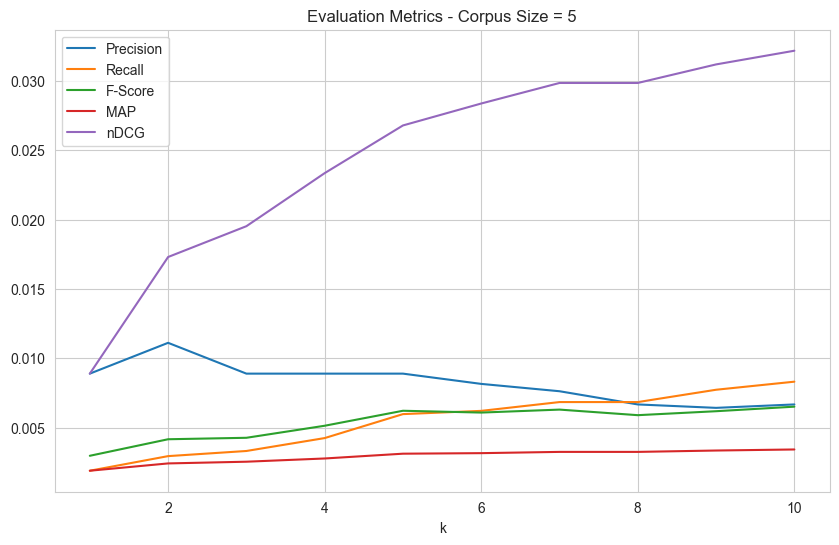

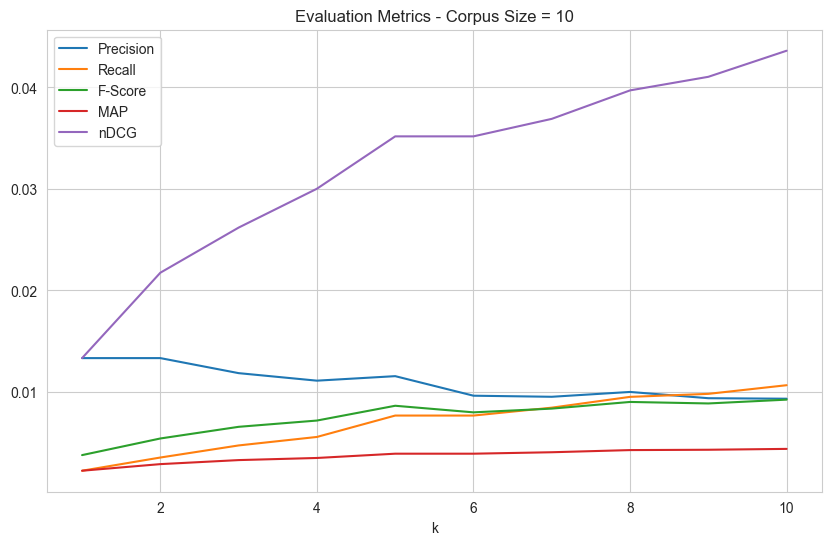

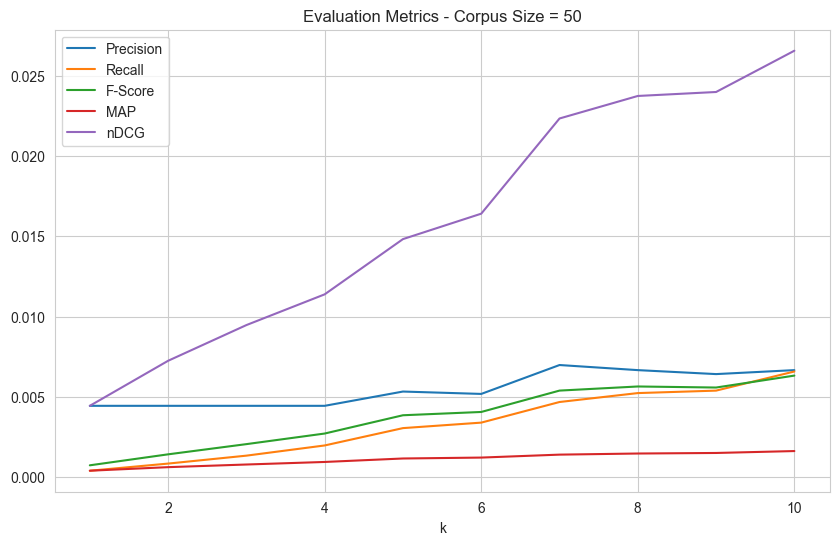

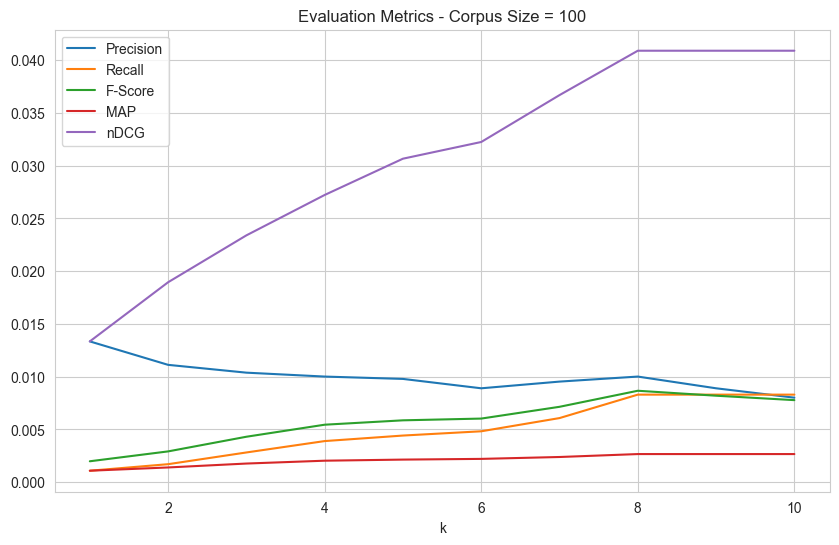

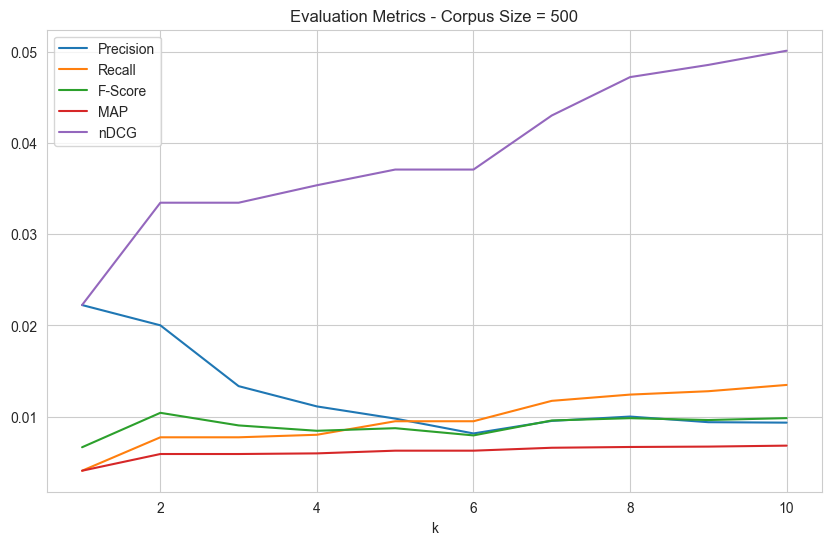

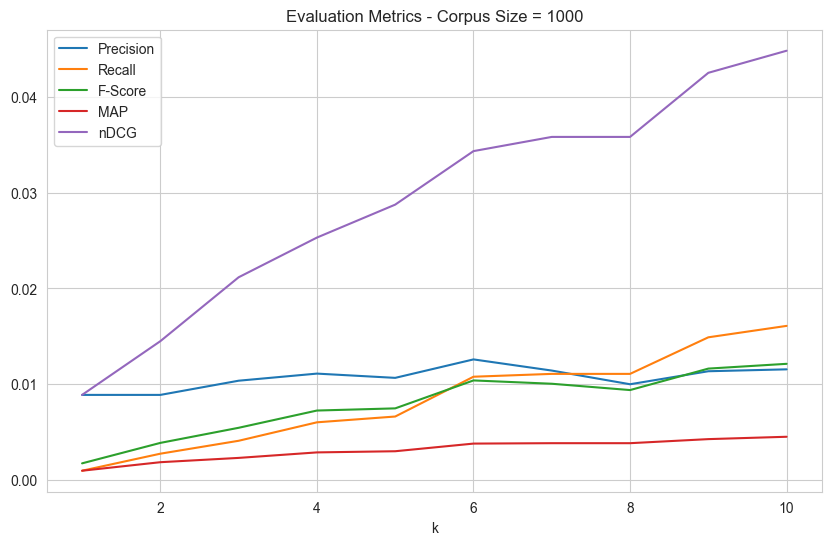

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from evaluation import Evaluation

if not os.path.exists("spreading_activation_esa"):

    os.makedirs("spreading_activation_esa")

corpus_sizes = [5, 10, 50, 100, 500, 1000]

for corpus_size in corpus_sizes:
    ir = SAESAInformationRetrieval(corpus_size=corpus_size)
    ir.build_vectors()

    queries_json = json.load(open("cranfield/cran_queries.json", 'r'))
    qrels = json.load(open("cranfield/cran_qrels.json", 'r'))

    query_ids, queries = [item["query number"] for item in queries_json], [item["query"] for item in queries_json]


    evaluator = Evaluation()

    doc_IDs_ordered = [ir.rank(query) for query in queries]

    precisions, recalls, fscores, MAPs, nDCGs = [], [], [], [], []

    for k in range(1, 11):
        precision = evaluator.meanPrecision(doc_IDs_ordered, query_ids, qrels, k)
        precisions.append(precision)
        recall = evaluator.meanRecall(doc_IDs_ordered, query_ids, qrels, k)
        recalls.append(recall)
        fscore = evaluator.meanFscore(doc_IDs_ordered, query_ids, qrels, k)
        fscores.append(fscore)
        #print("Precision, Recall and F-score @ " + str(k) + " : " + str(precision) + ", " + str(recall) + ", " + str(fscore))
        MAP = evaluator.meanAveragePrecision(doc_IDs_ordered, query_ids, qrels, k)
        MAPs.append(MAP)
        nDCG = evaluator.meanNDCG(doc_IDs_ordered, query_ids, qrels, k)
        nDCGs.append(nDCG)
        #print("MAP, nDCG @ " + str(k) + " : " + str(MAP) + ", " + str(nDCG))
    
    # Plot the metrics and save plot 
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    plt.plot(range(1, 11), precisions, label="Precision")
    plt.plot(range(1, 11), recalls, label="Recall")
    plt.plot(range(1, 11), fscores, label="F-Score")
    plt.plot(range(1, 11), MAPs, label="MAP")
    plt.plot(range(1, 11), nDCGs, label="nDCG")
    plt.legend()
    plt.title(f"Evaluation Metrics - Corpus Size = {corpus_size}")
    plt.xlabel("k")
    plt.savefig(f"spreading_activation_esa/eval_plot_{corpus_size}.png")
    plt.show()